In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm

In [2]:
# 1. Cargamos nuestros datos

df_final_demo = pd.read_csv('df_final_demo.csv')
df_final_experiment_clients = pd.read_csv('df_final_experiment_clients.csv')
df_final_web_data_1 = pd.read_csv('df_final_web_data_pt_1.csv')
df_final_web_data_2 = pd.read_csv('df_final_web_data_pt_2.csv')


In [3]:
# 2.  Unificamos los df_web y renombramos columnas para que sea más claro todo.
df_final_web_data = pd.concat([df_final_web_data_1, df_final_web_data_2], ignore_index=True)
df_final_web_data = df_final_web_data.rename(columns={
    'visit_id'   : 'visita_id',
    'visitor_id' : 'cliente_disp_id',
    'process_step': 'estado_proceso',
    'date_time'  : 'fecha_hora'
    })

In [4]:
# 3. Filtrado y unificación de tipos y orden
df_final_web_data['fecha_hora'] = pd.to_datetime(df_final_web_data['fecha_hora'], errors='coerce')


# Rango del experimento
start_date = '2017-03-15'
end_date   = '2017-06-20'
df_final_web_data = df_final_web_data[
    (df_final_web_data['fecha_hora'] >= start_date) &
    (df_final_web_data['fecha_hora'] <= end_date)
].copy()


# Orden lógico de pasos 
orden = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_final_web_data['estado_proceso'] = pd.Categorical(
    df_final_web_data['estado_proceso'], categories=orden, ordered=True
)
df_final_web_data = df_final_web_data.sort_values(['visita_id', 'fecha_hora']).reset_index(drop=True)
df_final_web_data

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora
0,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17
1,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09
2,9056452,306992881_89423906595,1000165_4190026492_760066,start,2017-06-04 01:07:29
3,9056452,306992881_89423906595,1000165_4190026492_760066,step_1,2017-06-04 01:07:32
4,9056452,306992881_89423906595,1000165_4190026492_760066,step_2,2017-06-04 01:07:56
...,...,...,...,...,...
747568,7149380,483112224_46340533900,999992932_41666455053_671149,step_1,2017-06-06 15:46:24
747569,7149380,483112224_46340533900,999992932_41666455053_671149,step_2,2017-06-06 15:47:32
747570,7149380,483112224_46340533900,999992932_41666455053_671149,step_3,2017-06-06 16:01:46
747571,7149380,483112224_46340533900,999992932_41666455053_671149,confirm,2017-06-06 16:04:08


In [5]:
#4. Limpieza/renombre las columnas de demo:
df_final_demo = df_final_demo.rename(columns={
    'clnt_tenure_yr' : 'años_cliente_vg',
    'clnt_tenure_mnth': 'meses_cliente_vg',
    'gendr'          : 'genero',
    'clnt_age'       : 'edad',
    'num_accts'      : 'num_cuentas',
    'calls_6_mnth'   : 'llamadas_6_meses',
    'logons_6_mnth'  : 'logins_6_meses',
    'bal'            : 'saldo_total'
})

# Función simple para pasar a enteros.
def cambio_entero(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').round().astype('Int64')
    return df
df_final_demo = cambio_entero(df_final_demo, [
    'años_cliente_vg','meses_cliente_vg','num_cuentas',
    'llamadas_6_meses','logins_6_meses','edad'
])
# Filtramos géneros
df_final_demo_1 = df_final_demo.query("genero not in ['U','other','X']").copy()

In [6]:
# 5. Eliminamos los nulos de la tabla df_final_experiment_clients 
# y normalizamos su nombre.
df_final_experiment_clients.rename(columns={'Variation': 'variation'}, inplace=True)
df_final_experiment_clients=df_final_experiment_clients.dropna()
df_final_experiment_clients

,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


In [7]:
# --- 0) Asegura tipos y orden ---
df_final_web_data['fecha_hora'] = pd.to_datetime(df_final_web_data['fecha_hora'], errors='coerce')
df_final_web_data = df_final_web_data.sort_values(['visita_id','fecha_hora'])
# --- 1) Calcula el primer evento REAL de cada visita (sin filtrar por fechas todavía) ---
first_event = (
    df_final_web_data
    .groupby('visita_id', as_index=False)
    .agg(first_time=('fecha_hora','first'),
         first_step=('estado_proceso','first'))
)
# --- 2) Selecciona las visitas cuyo INICIO de sesión cae en tu ventana ---
ini = pd.Timestamp('2017-03-15')
fin = pd.Timestamp('2017-06-20')
visitas_ok = set(first_event.loc[(first_event['first_time']>=ini) & (first_event['first_time']<=fin), 'visita_id'])
# --- 3) Quédate con TODOS los eventos de esas visitas (sesiones completas) ---
df_web_filtrado = df_final_web_data[df_final_web_data['visita_id'].isin(visitas_ok)].copy()






# Ejemplo típico de merge para tu master (ajusta nombres a los tuyos):
df_master = (
    df_web_filtrado
    .merge(df_final_experiment_clients, on='visita_id', how='left')  # si lo usas
    .merge(df_final_demo, on='client_id', how='left')                 # si lo usas
    .sort_values(['visita_id','fecha_hora'])
)

df_visitas = df_master.groupby('visita_id', as_index=False).agg(
    client_id   = ('client_id','first'),
    variation   = ('variation','first'),
    primer_paso = ('estado_proceso','first'),
    ultimo_paso = ('estado_proceso','last'),
    t_total    


_IncompleteInputError: incomplete input (1463396445.py, line 36)

In [ ]:
# 6. Procedemos a hacer los merge oportunos.
web     = df_final_web_data
clients = df_final_experiment_clients
demo    = df_final_demo_1
# 6.1) web + experimento
web_clients = web.merge(clients[['client_id','variation']], on='client_id', how='left')
# 6.2) + demografía
df_master = web_clients.merge(demo, on='client_id', how='left')
# 7 checkeamos:
print("variation:\n", df_master['variation'].value_counts(dropna=False))
print("Pct sin variation:", df_master['variation'].isna().mean())
print("Columnas df_master:", df_master.columns.tolist()[:20], "... total:", df_master.shape)

variation:
 variation
NaN        428052
Test       177114
Control    142407
Name: count, dtype: int64
Pct sin variation: 0.5725888976728694
Columnas df_master: ['client_id', 'cliente_disp_id', 'visita_id', 'estado_proceso', 'fecha_hora', 'variation', 'años_cliente_vg', 'meses_cliente_vg', 'edad', 'genero', 'num_cuentas', 'saldo_total', 'llamadas_6_meses', 'logins_6_meses'] ... total: (747573, 14)


In [ ]:
df_master = df_master.dropna()

In [ ]:
df_master

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
7,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7,88,24,M,2,26436.73,6,9
8,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7,88,24,M,2,26436.73,6,9
9,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7,88,24,M,2,26436.73,6,9
10,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7,88,24,M,2,26436.73,6,9
11,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7,88,24,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747559,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,18,227,58,F,2,1056775.54,6,9
747560,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,18,227,58,F,2,1056775.54,6,9
747561,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,18,227,58,F,2,1056775.54,6,9
747562,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,18,227,58,F,2,1056775.54,6,9


In [ ]:
df_master = df_master[df_master['variation'] != 'Nan']
df_master

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
7,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7,88,24,M,2,26436.73,6,9
8,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7,88,24,M,2,26436.73,6,9
9,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7,88,24,M,2,26436.73,6,9
10,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7,88,24,M,2,26436.73,6,9
11,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7,88,24,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747559,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,18,227,58,F,2,1056775.54,6,9
747560,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,18,227,58,F,2,1056775.54,6,9
747561,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,18,227,58,F,2,1056775.54,6,9
747562,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,18,227,58,F,2,1056775.54,6,9


In [ ]:
df_master = df_master.sort_values(['visita_id', 'fecha_hora'])
df_master

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
7,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7,88,24,M,2,26436.73,6,9
8,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7,88,24,M,2,26436.73,6,9
9,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7,88,24,M,2,26436.73,6,9
10,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7,88,24,M,2,26436.73,6,9
11,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7,88,24,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747559,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,18,227,58,F,2,1056775.54,6,9
747560,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,18,227,58,F,2,1056775.54,6,9
747561,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,18,227,58,F,2,1056775.54,6,9
747562,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,18,227,58,F,2,1056775.54,6,9


Comenzamos el analisis demografico  a partir del df "df_master"

In [ ]:
# Definir los límites de los grupos
bins = [0, 18, 25, 35, 45, 55, 65, 80, float('inf')]

# Definir las etiquetas correspondientes
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '66-80', '+80']

# Crear la nueva columna
df_master['grupo_edad'] = pd.cut(df_master['edad'], bins=bins, labels=labels, right=True, include_lowest=True)

# Ver los primeros resultados
print(df_master[['edad', 'grupo_edad']].head())

    edad grupo_edad
7     24      18-25
8     24      18-25
9     24      18-25
10    24      18-25
11    24      18-25


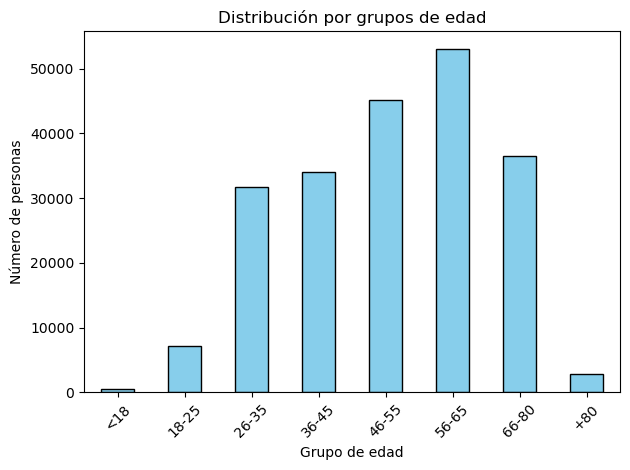

In [ ]:


# Contar cuántos hay en cada grupo de edad
conteo = df_master['grupo_edad'].value_counts().sort_index()

# Crear el gráfico de barras
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Títulos y etiquetas
plt.title("Distribución por grupos de edad")
plt.xlabel("Grupo de edad")
plt.ylabel("Número de personas")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Vamos a ver la media de Saldo Total que tienen estos grupos de edad:

In [ ]:
media_saldo = (
    df_master.groupby('grupo_edad', observed=False)['saldo_total']
    .mean()
    .reset_index()
    .sort_values('grupo_edad')
)
print(media_saldo)

  grupo_edad    saldo_total
0        <18   45578.114500
1      18-25   62717.227041
2      26-35   88443.606742
3      36-45  135940.546692
4      46-55  191330.217594
5      56-65  242710.716350
6      66-80  281325.870589
7        +80  330300.692293


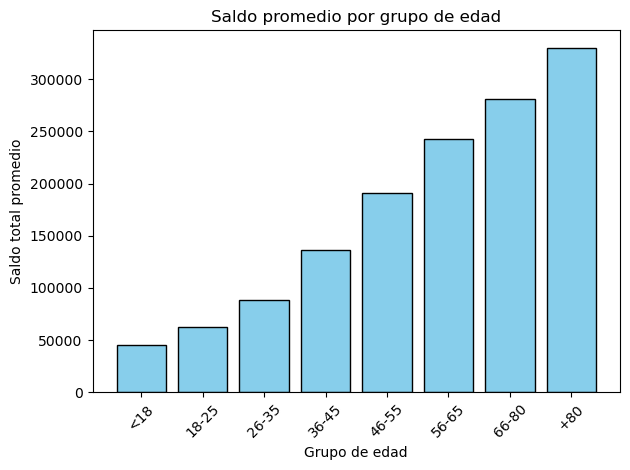

In [ ]:

plt.bar(media_saldo['grupo_edad'], media_saldo['saldo_total'], color='skyblue', edgecolor='black')
plt.title("Saldo promedio por grupo de edad")
plt.xlabel("Grupo de edad")
plt.ylabel("Saldo total promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
media_80 = df_master.loc[df_master['grupo_edad'] == '+80', 'num_cuentas'].mean()
print("Media de cuentas en el grupo +80:", media_80)


Media de cuentas en el grupo +80: 2.35


De momento nos interesan cleintes entre 56 y 80 años ya que son los grupos que más media de saldo total tienen en sus cuentas respecto a  lo numerosos que son.

In [ ]:
filtro_edad = df_master[df_master['grupo_edad'].isin(['56-65', '66-80'])]
porcentaje_sexo = filtro_edad['genero'].value_counts(normalize=True) * 100
porcentaje_sexo

genero
F    50.365469
M    49.634531
Name: proportion, dtype: float64

In [ ]:
media_saldo = filtro_edad.groupby('genero')['saldo_total'].mean().round(2)
media_saldo

genero
F    184198.68
M    333755.83
Name: saldo_total, dtype: float64

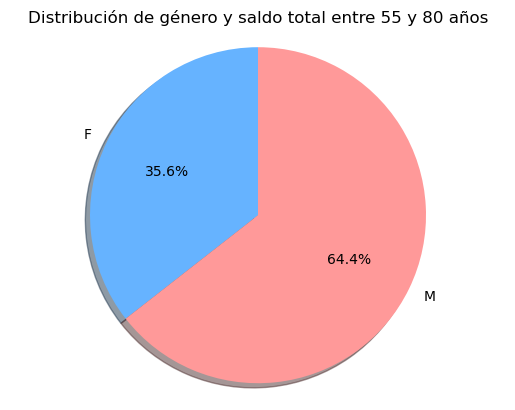

In [ ]:
plt.pie(
    media_saldo,
    labels=media_saldo.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    shadow=True
)

plt.title("Distribución de género y saldo total entre 55 y 80 años")
plt.axis('equal')
plt.show()

Vemos que de media los hombres en ese rango de edad tienen casi 1/3 más de saldo total en sus cuentas. Por lo tanto, nos interesan más.

Nuestro Cliente Principal son varones entre 55 y 80 años. Primarán los que llevan más tiempo usando la aplicación o por el contrario llevarán poco?

In [ ]:
filtro_hombres = df_master[(df_master['grupo_edad'].isin(['56-65', '66-80'])) &(df_master['genero'] == 'M')]

In [ ]:
media_tiempo_app = filtro_hombres['años_cliente_vg'].mean()
media_tiempo_app

np.float64(16.26442286074014)

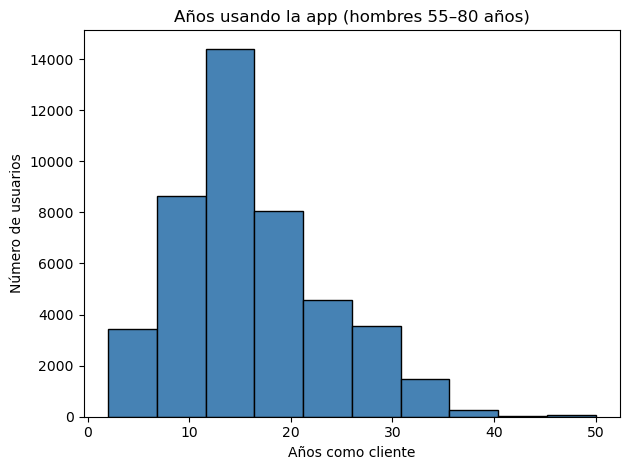

In [ ]:
plt.hist(filtro_hombres['años_cliente_vg'], bins=10, color='steelblue', edgecolor='black')
plt.title("Años usando la app (hombres 55–80 años)")
plt.xlabel("Años como cliente")
plt.ylabel("Número de usuarios")
plt.tight_layout()
plt.show()

Por lo tanto nuestro perfil de Cliente Principal es un varón de entre 55 y 80 años que lleva varios años registrado.

## Vamos a por la parte de filtar por las KPI. 
#### Necesitamos quedarnos con las columnas clave 'visita_id','client_id','variation','estado_proceso','fecha_hora'.

In [ ]:
df_visitas=df_master[['visita_id','client_id','variation','estado_proceso','fecha_hora']].head()

In [ ]:
g = df_master.groupby('visita_id', as_index=False)
g

In [ ]:
#TENEMOS QUE SACAR TIEMPO POR PASO
#TASA DE ERROR (SI VUELVE A UN PASO ANTERIOR O NO)  CON FUNCION SHIFT Y MAPEANDO LOS PASOS A NUMÉRICO

In [ ]:
df_visitas = g.agg(
    client_id    = ('client_id', 'first'),
    variation    = ('variation', 'first'),
    primer_paso  = ('estado_proceso', 'first'),
    ultimo_paso  = ('estado_proceso', 'max'),
    t_total      = ('fecha_hora', lambda s: (s.max() - s.min()).total_seconds())
)

df_visitas['finaliza'] = (df_visitas['ultimo_paso'] == 'confirm').astype(int)

In [ ]:
df_visitas

,visita_id,client_id,variation,primer_paso,ultimo_paso,t_total,finaliza
0,100019538_17884295066_43909,7338123,Test,start,confirm,242.0,1
1,100022086_87870757897_149620,2478628,Test,start,confirm,180.0,1
2,100030127_47967100085_936361,105007,Control,start,start,0.0,0
3,100037962_47432393712_705583,5623007,Control,start,step_1,132.0,0
4,10006594_66157970412_679648,3479519,Control,start,confirm,354.0,1
...,...,...,...,...,...,...,...
45998,999960019_60838685252_926860,1498554,Test,start,step_2,1709.0,0
45999,999971096_28827267783_236076,2979920,Test,start,confirm,139.0,1
46000,999976049_95772503197_182554,4449968,Test,start,confirm,728.0,1
46001,999984454_18731538378_781808,829911,Test,start,confirm,154.0,1


In [ ]:
#Suponemos que nadie debería tener como primer paso nada que no sea start 
# y que es un error, por lo tanto vamos a auditarlas.
no_start = df_visitas.query("primer_paso != 'start'")
total = len(df_visitas)
print(f"Visitas sin 'start' como primer paso: {len(no_start)}")
print(no_start['primer_paso'].value_counts())


Visitas sin 'start' como primer paso: 3914
primer_paso
confirm    3070
step_1      396
step_3      275
step_2      173
start         0
Name: count, dtype: int64


In [ ]:
df_visitas

,visita_id,client_id,variation,primer_paso,ultimo_paso,t_total,finaliza
0,100019538_17884295066_43909,7338123,Test,start,confirm,242.0,1
1,100022086_87870757897_149620,2478628,Test,start,confirm,180.0,1
2,100030127_47967100085_936361,105007,Control,start,start,0.0,0
3,100037962_47432393712_705583,5623007,Control,start,step_1,132.0,0
4,10006594_66157970412_679648,3479519,Control,start,confirm,354.0,1
...,...,...,...,...,...,...,...
45998,999960019_60838685252_926860,1498554,Test,start,step_2,1709.0,0
45999,999971096_28827267783_236076,2979920,Test,start,confirm,139.0,1
46000,999976049_95772503197_182554,4449968,Test,start,confirm,728.0,1
46001,999984454_18731538378_781808,829911,Test,start,confirm,154.0,1


## Calculamos las métricas básicas por grupo:
### Vamos a calcular número de visitas, % de finalización, tiempo medio total (s y min) y mediana por grupo

In [ ]:
kpi_base = (
    df_visitas
    .groupby('variation', as_index=False)
    .agg(
        n_visitas=('visita_id','nunique'),
        tasa_finaliza=('finaliza','mean'),
        t_total_medio_s=('t_total','mean'),
        t_total_mediana_s=('t_total','median')
    )
)

kpi_base['tasa_finaliza_porc'] = (kpi_base['tasa_finaliza']*100).round(2)
kpi_base['t_total_medio_min'] = (kpi_base['t_total_medio_s']/60).round(2)

kpi_base

,variation,n_visitas,tasa_finaliza,t_total_medio_s,t_total_mediana_s,tasa_finaliza_porc,t_total_medio_min
0,Control,21317,0.489234,283.575878,160.0,48.92,4.73
1,Test,24686,0.581909,319.343717,170.0,58.19,5.32


##  Tiempo medio por paso (velocidad del proceso)
### Sirve para ver qué pasos son más lentos y si el Test acelera alguno.

In [ ]:
#Tiempo medio por paso 
df_seq = (
    df_master[['visita_id','variation','estado_proceso','fecha_hora']]
    .sort_values(['visita_id','fecha_hora'])
    .copy()
)
# Siguiente paso y tiempo dentro de cada visita
df_seq['next_step'] = df_seq.groupby('visita_id')['estado_proceso'].shift(-1)
df_seq['next_time'] = df_seq.groupby('visita_id')['fecha_hora'].shift(-1)
# Diferencia en segundos entre eventos consecutivos
df_seq['dt_sec'] = (df_seq['next_time'] - df_seq['fecha_hora']).dt.total_seconds()
# Mantenemos solo transiciones válidas
df_trans = df_seq.dropna(subset=['next_step','dt_sec']).copy()
# Etiqueta de transición (castea a string para evitar el error con Categorical)
df_trans['transition'] = (
    df_trans['estado_proceso'].astype('string')
          .str.cat(df_trans['next_step'].astype('string'), sep='-')
)
# Agregación correcta (NO seleccionar la serie antes de agg)
df_tiempos = (
    df_trans
    .groupby(['variation','transition'], as_index=False)
    .agg(
        media_s   = ('dt_sec','mean'),
        mediana_s = ('dt_sec','median'),
        n         = ('dt_sec','size')
    )
    .sort_values(['variation','transition'])
)
df_tiempos

,variation,transition,media_s,mediana_s,n
0,Control,confirm-confirm,138.261003,25.0,977
1,Control,confirm-start,258.152062,120.0,388
2,Control,confirm-step_1,74.290323,40.0,93
3,Control,confirm-step_3,3.850000,0.0,80
4,Control,start-confirm,220.500000,217.5,4
5,Control,start-start,112.882879,25.0,7932
6,Control,start-step_1,38.865613,18.0,16951
7,Control,start-step_2,35.301075,15.0,93
8,Control,start-step_3,233.451613,51.0,124
9,Control,step_1-confirm,499.500000,499.5,2


In [ ]:
# === Tasa de error (retrocesos) por grupo ===
orden = ['start','step_1','step_2','step_3','confirm']
rank = {p:i for i,p in enumerate(orden)}
df_seq = (
    df_master[['visita_id','variation','estado_proceso','fecha_hora']]
    .sort_values(['visita_id','fecha_hora'])
    .copy()
)
# Paso anterior dentro de cada visita
df_seq['prev_step'] = df_seq.groupby('visita_id')['estado_proceso'].shift(1)
# Un retroceso ocurre cuando el paso actual es "menor" que el anterior en el orden del funnel
def retrocede(cur, prev):
    if pd.isna(cur) or pd.isna(prev):
        return 0
    return int(rank[str(cur)] < rank[str(prev)])
df_seq['retroceso'] = df_seq.apply(lambda r: retrocede(r['estado_proceso'], r['prev_step']), axis=1)
# Tasa de error por grupo
error_rate = (
    df_seq.groupby('variation', as_index=False)
          .agg(retrocesos=('retroceso','sum'), total_eventos=('estado_proceso','size'))
          .assign(tasa_error=lambda d: (d['retrocesos'] / d['total_eventos']).round(4),
                  tasa_error_porc=lambda d: (d['tasa_error']*100).round(2))
)
error_rate

,variation,retrocesos,total_eventos,tasa_error,tasa_error_porc
0,Control,6063,93294,0.065,6.5
1,Test,11076,117776,0.094,9.4


In [ ]:
# === KPI FINAL (tabla de presentación) ===
# Base: KPIs por grupo a nivel de visita
kpi_base = (
    df_visitas
    .groupby('variation', as_index=False)
    .agg(
        n_visitas         = ('visita_id','nunique'),
        tasa_finaliza     = ('finaliza','mean'),
        t_total_medio_s   = ('t_total','mean'),
        t_total_mediana_s = ('t_total','median')
    )
)
# Une la tasa de error calculada en la celda anterior
kpi = (
    kpi_base
    .merge(error_rate[['variation','tasa_error','tasa_error_porc']], on='variation', how='left')
)
# Formato amigable
kpi['tasa_finaliza_porc'] = (kpi['tasa_finaliza']*100).round(2)
kpi['t_total_medio_min'] = (kpi['t_total_medio_s']/60).round(2)
# Ordenar Control → Test si aplica
orden_var = pd.CategoricalDtype(categories=['Control','Test'], ordered=True)
if kpi['variation'].isin(['Control','Test']).all():
    kpi['variation'] = kpi['variation'].astype(orden_var)
    kpi = kpi.sort_values('variation')
# Selección de columnas para mostrar
kpi_final = kpi[[
    'variation','n_visitas','tasa_finaliza_porc','t_total_medio_s','t_total_mediana_s','t_total_medio_min','tasa_error_porc'
]].reset_index(drop=True)
kpi_final

,variation,n_visitas,tasa_finaliza_porc,t_total_medio_s,t_total_mediana_s,t_total_medio_min,tasa_error_porc
0,Control,21317,48.92,283.575878,160.0,4.73,6.5
1,Test,24686,58.19,319.343717,170.0,5.32,9.4


## Procedemos a las gráficas:

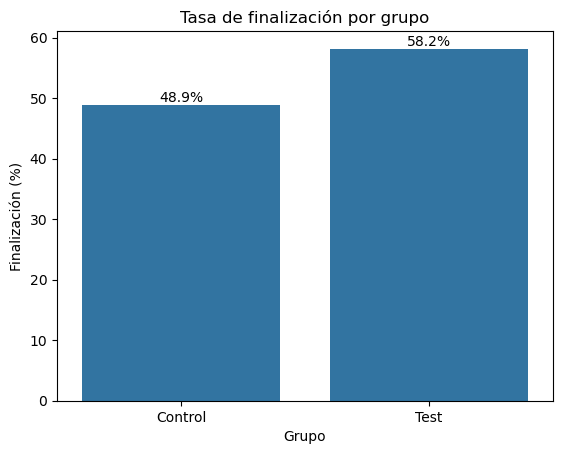

In [ ]:
## 1) Tasa de finalización
ax = sns.barplot(data=kpi_final, x='variation', y='tasa_finaliza_porc')
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_title("Tasa de finalización por grupo")
ax.set_xlabel("Grupo")
ax.set_ylabel("Finalización (%)")
plt.show()

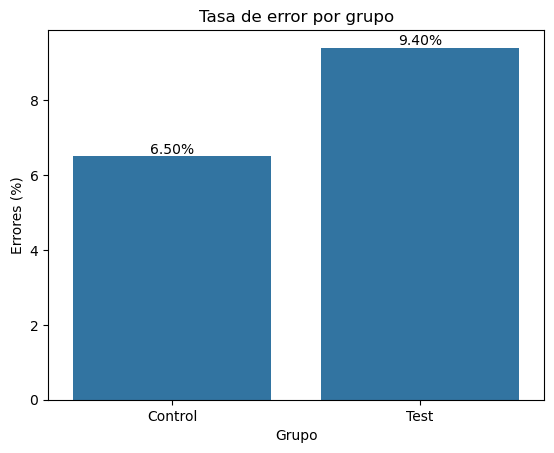

In [ ]:
#2) Tasa de error
ax = sns.barplot(data=kpi_final, x='variation', y='tasa_error_porc')
ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set_title("Tasa de error por grupo")
ax.set_xlabel("Grupo")
ax.set_ylabel("Errores (%)")
plt.show()

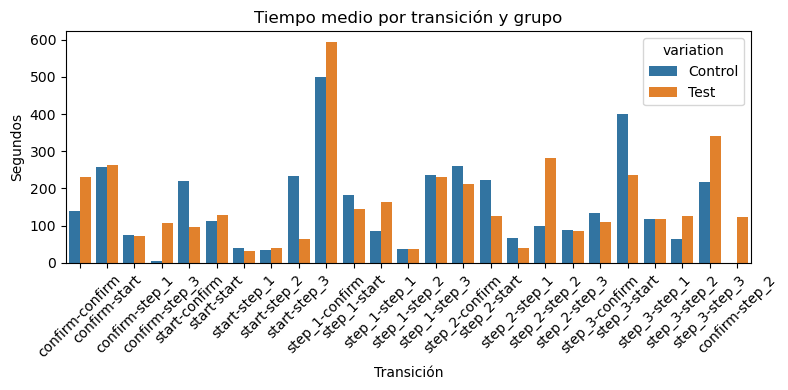

In [ ]:
# 3 Tiempo medio por transición (start-step_1, etc.) 
plt.figure(figsize=(8,4))
ax = sns.barplot(data=df_tiempos, x='transition', y='media_s', hue='variation')
ax.set_title("Tiempo medio por transición y grupo")
ax.set_xlabel("Transición")
ax.set_ylabel("Segundos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

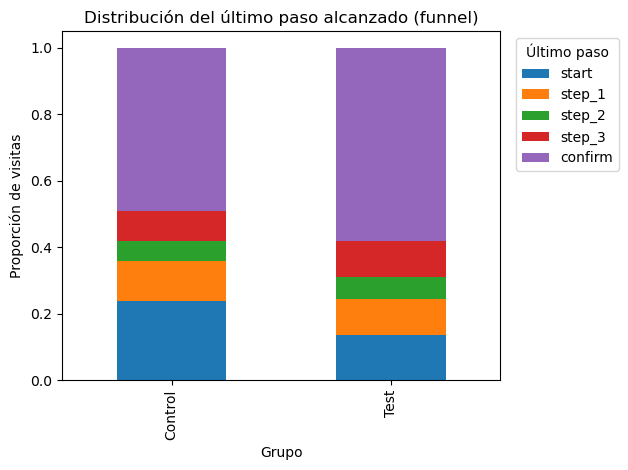

In [ ]:
#Último paso alcanzado por visita
orden_pasos = ['start','step_1','step_2','step_3','confirm']

ultimo_paso_visita = (
    df_master.sort_values(['visita_id','fecha_hora'])
             .groupby(['visita_id','variation'], as_index=False)
             .agg(ultimo_paso=('estado_proceso','max'))
)

drop_counts = (
    ultimo_paso_visita.value_counts(['variation','ultimo_paso'])
                      .rename('n_visitas').reset_index()
)
totales = drop_counts.groupby('variation')['n_visitas'].sum().rename('n_total')
drop_counts = drop_counts.merge(totales, on='variation', how='left')
drop_counts['pct'] = drop_counts['n_visitas'] / drop_counts['n_total']

pivot_drop = (drop_counts
              .pivot(index='variation', columns='ultimo_paso', values='pct')
              .reindex(columns=orden_pasos, fill_value=0))

pivot_drop.plot(kind='bar', stacked=True)
plt.title("Distribución del último paso alcanzado (funnel)")
plt.xlabel("Grupo")
plt.ylabel("Proporción de visitas")
plt.legend(title='Último paso', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Paso 1: contemos las visitas y las que completan el proceso 

In [ ]:
# Seleccionamos los datos por grupo
grupo_control = df_visitas[df_visitas['variation'] == 'Control']
grupo_test    = df_visitas[df_visitas['variation'] == 'Test']

# Cuántas visitas tiene cada grupo
total_visitas_control = len(grupo_control)
total_visitas_test = len(grupo_test)

# Cuántas de esas visitas llegaron a "confirm"
exitos_control = grupo_control['finaliza'].sum()
exitos_test = grupo_test['finaliza'].sum()

# Calculamos la tasa de finalización (porcentaje)
prop_control = exitos_control / total_visitas_control
prop_test = exitos_test / total_visitas_test

print(f"Control: {prop_control} ")
print(f"Test: {prop_test}")

Control: 0.4892339447389408 
Test: 0.5819087742040022


## Paso 2: prueba de hipótesis.
- **Hipótesis nula (H0)**: “El nuevo diseño **no cambia** la tasa de finalización.”

- **Hipótesis alternativa (H₁)**: “El nuevo diseño **sí cambia** la tasa de finalización.”


In [ ]:
# Proporción combinada (como si los dos grupos fueran uno solo)
p_pool = (exitos_control + exitos_test) / (total_visitas_control + total_visitas_test)

# Error estándar (variabilidad de la diferencia)
se = sqrt(p_pool * (1 - p_pool) * (1/total_visitas_control + 1/total_visitas_test))

# Estadístico Z
z = (prop_test - prop_control) / se

# P-valor bilateral (dos colas)
p_valor = 2 * norm.sf(abs(z))

print(f"Z = {z:.3f}")
print(f"P-valor = {p_valor}")


Z = 19.884
P-valor = 5.567501789623837e-88


### Como el p_value es mucho menor que 0.05, podemos descartar la hipótesis nula y aceptar la alternativa, es decir, el nuevo diseño sí cambia la tasa de finalización en positivo.

### Queremos saber si **el nuevo diseño mejora al menos +5 %** sobre el viejo.

##### * **H₀:** el Test mejora **menos o igual a +5 %**
##### * **H₁:** el Test mejora **más de +5 %**
##### * Es una prueba **unilateral (solo miramos si mejora)**.

In [ ]:


#p_c    Porcentaje que termina con el diseño viejo
#p_t    Porcentaje que termina con el diseño nuevo
#p0    La meta (+5 % más que el viejo)
#se_thr    Cuánto puede cambiar el resultado solo por azar
#z_thr    Qué tan por encima del umbral está el nuevo diseño
#p_valor_thr    Probabilidad de que todo sea casualidad

# Umbral objetivo: +5 pp 
p0 = prop_control + 0.05  # lo que esperaríamos si mejora justo 5 puntos

# Error estándar de este umbral
se_thr = sqrt(p0 * (1 - p0) / total_visitas_test)

# Z y p-valor
z_thr = (prop_test - p0) / se_thr
p_valor_thr = norm.sf(z_thr)

print(f"Z umbral = {z_thr:.3f}")
print(f"P-valor = {p_valor_thr}")

Z umbral = 13.451
P-valor = 1.5099712797840336e-41


### Como el z umbral es muy alto y el P-valor inferior a 0.05, podemos afirmar que hay una mejora mayor al 5%  y que dicha mejora no se debe al azar